In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import palettable

sns.set(style='whitegrid', font_scale=1.75)

from palettable.cartocolors.qualitative import *

In [2]:
api = wandb.Api()

In [3]:
tasks = [
#     'lambo.tasks.regex.RegexTask',
#     'lambo.tasks.chem.chem.ChemTask',
#     'lambo.tasks.proxy_rfp.proxy_rfp.ProxyRFPTask',
    'regex',
    'chem',
    'proxy_rfp',
]

optimizers = [
    'lambo.optimizers.pymoo.ModelFreeGeneticOptimizer',
    'lambo.optimizers.pymoo.ModelBasedGeneticOptimizer',
    'lambo.optimizers.lambo.LaMBO',
]

surrogates = [
    'lambo.models.gp_models.MultiTaskExactGP',
]

## Benchmark against genetic optimizers

In [4]:
result_queries = [
    {
        'label': 'NSGA-2 (Model-Free)',
        'color': Bold_7.hex_colors[5],
        'filters': {
            'config.config/optimizer/_target_': optimizers[0],
            'config.config/version': 'v0.2.0',
            'config.config/exp_name': 'bbo_benchmark',
        },
    },
    {
        'label': 'MTGP + NEHVI + GA',
        'color': Bold_7.hex_colors[2],
        'filters': {
            'config.config/optimizer/_target_': optimizers[1],
            'config.config/surrogate/_target_': surrogates[0],
            'config.config/version': 'v0.2.0',
            'config.config/exp_name': 'bbo_benchmark',
        },
    },
#     {
#         'label': 'DAE samples',
#         'color': Bold_7.hex_colors[1],
#         'filters': {
#             'config.config/optimizer/_target_': optimizers[2],
#             'config.config/surrogate/_target_': surrogates[0],
#             'config.config/version': 'v0.2.0',
#             'config.config/optimizer/optimize_latent': False,
#             'config.config/exp_name': 'lambo_ablation',
#         },
#     },
#     {
#         'label': 'DAE samples + latent grad',
#         'color': Bold_7.hex_colors[3],
#         'filters': {
#             'config.config/optimizer/_target_': optimizers[2],
#             'config.config/surrogate/_target_': surrogates[0],
#             'config.config/version': 'v0.2.0',
#             'config.config/optimizer/entropy_penalty': 0,
#             'config.config/optimizer/optimize_latent': True,
#             'config.config/exp_name': 'lambo_ablation',
#         },
#     },
    {
        'label': 'LaMBO',
        'color': Bold_7.hex_colors[0],
        'filters': {
            'config.config/optimizer/_target_': optimizers[2],
            'config.config/surrogate/_target_': surrogates[0],
            'config.config/version': 'v0.2.0',
            'config.config/optimizer/entropy_penalty': 1e-2,
            'config.config/optimizer/optimize_latent': True,
            'config.config/exp_name': 'bbo_benchmark',
        },
    },
]

10
10
10
10
10
10
10
10
10


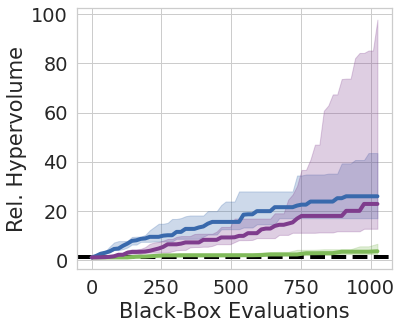

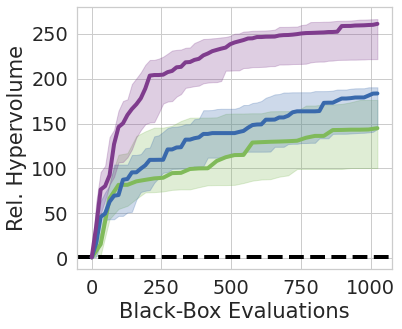

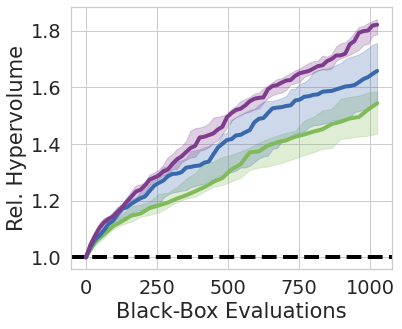

In [5]:
key = 'hypervol_rel'

for task in tasks:
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    for query in result_queries:
               
        filters = {
            'config.config/task/log_prefix': task,
            'config.config/task/num_start_examples': 512
        }
        filters.update(query['filters'])
        
        runs = api.runs(
            path='samuelstanton/lambo',
            filters=filters
        )
        history = [r.scan_history() for r in runs]
        
        if len(history) == 0:
            continue
        else:
            print(len(history))
            
        df = pd.concat([pd.DataFrame(h) for h in history])
        x_col = [c for c in df.columns if 'num_bb_evals' in c]
        y_col = [c for c in df.columns if key in c]
        
        y_med = df.groupby(x_col)[y_col].quantile(
            0.5, interpolation='linear'
        )
        y_med = pd.DataFrame(y_med.to_records())
        y_med.sort_values(x_col, inplace=True)
        
        y_lb = df.groupby(x_col)[y_col].quantile(
            0.2, interpolation='linear'
        )
        y_lb = pd.DataFrame(y_lb.to_records())
        y_lb.sort_values(x_col, inplace=True)
        y_lb = y_lb[y_col].values.reshape(-1)
        
        y_ub = df.groupby(x_col)[y_col].quantile(
            0.8, interpolation='linear'
        )
        y_ub = pd.DataFrame(y_ub.to_records())
        y_ub.sort_values(x_col, inplace=True)
        y_ub = y_ub[y_col].values.reshape(-1)
        
        x_vals = y_med[x_col].values.reshape(-1)
        y_vals = y_med[y_col].values.reshape(-1)
        
        ax.plot(x_vals, y_vals, linewidth=4, zorder=3, color=query['color'], label=query['label'])
        ax.fill_between(x_vals, y_lb, y_ub, alpha=0.25, color=query['color'])
        
    ax.set_xlim(plt.xlim())
    ax.hlines(y_vals[0], *plt.xlim(), color='black', linestyle='--', linewidth=4, zorder=2)
        
    ax.set_xlabel('Black-Box Evaluations')
    ax.set_ylabel('Rel. Hypervolume')
        
    plt.tight_layout()
    task_name = task.replace('_', '-')
    q_version = query["filters"]["config.config/version"]
    plt.savefig(f"./figures/bbo_benchmark_{key.replace('_', '-')}_{task_name}_{q_version}.pdf")

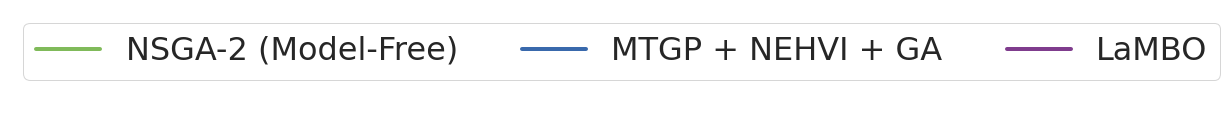

In [6]:
figlegend = plt.figure(figsize=(2,2))
handles = ax.get_legend_handles_labels()
plt.legend(*handles, 
           loc ='upper left',
           fontsize=32,
           ncol=4
          )
plt.axis("off")
plt.savefig(
    f"./figures/bbo_benchmark_{key.replace('_', '-')}_legend_{q_version}.pdf", bbox_inches="tight"
)